# Notebook 4: Hierarchical Models

[Bayesian Inference with PyMC](https://allendowney.github.io/BayesianInferencePyMC)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install PyMC and ArviZ
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pymc3
    !pip install arviz

In [2]:
# PyMC generates a FutureWarning we don't need to deal with yet

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import seaborn as sns

def plot_hist(sample, **options):
    """Plot a histogram of goals.
    
    sample: sequence of values
    """
    sns.histplot(sample, stat='probability', discrete=True,
                 alpha=0.5, **options)

In [4]:
def plot_kde(sample, **options):
    """Plot a distribution using KDE.
    
    sample: sequence of values
    """
    sns.kdeplot(sample, cut=0, **options)

In [5]:
import matplotlib.pyplot as plt

def legend(**options):
    """Make a legend only if there are labels."""
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend(**options)

In [6]:
def decorate_heads(ylabel='Probability'):
    """Decorate the axes."""
    plt.xlabel('Number of heads (k)')
    plt.ylabel(ylabel)
    plt.title('Distribution of heads')
    legend()

In [7]:
def decorate_proportion(ylabel='Likelihood'):
    """Decorate the axes."""
    plt.xlabel('Proportion of heads (x)')
    plt.ylabel(ylabel)
    plt.title('Distribution of proportion')
    legend()

## Two coins

In the previous notebook, we solved a version of the Euro problem, where we estimated the probability that a coin would come up heads.

Now suppose instead of one coin, we have data from two coins.
We spin each coin 250 times.
The first one comes up heads 140 times, as in the previous example.
The second one comes up heads 120 times.

As we did in the hockey example, we can extend the model to estimate the proportion of heads for each coin separately.
Here's a PyMC model that does that.

In [8]:
import pymc3 as pm

n = 250
with pm.Model() as model1:
    x1 = pm.Beta('x1', alpha=2, beta=2)
    x2 = pm.Beta('x2', alpha=2, beta=2)
    k1 = pm.Binomial('k1', n=n, p=x1, observed=140)
    k2 = pm.Binomial('k2', n=n, p=x2, observed=110)    

Here's the graphical representation of the model.

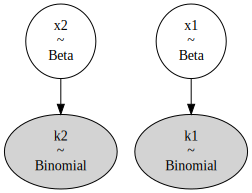

In [9]:
pm.model_to_graphviz(model1)

Now let's run the sampler.

In [10]:
with model1:
    trace1 = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x2, x1]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


Here are the posterior distributions for the two coins.

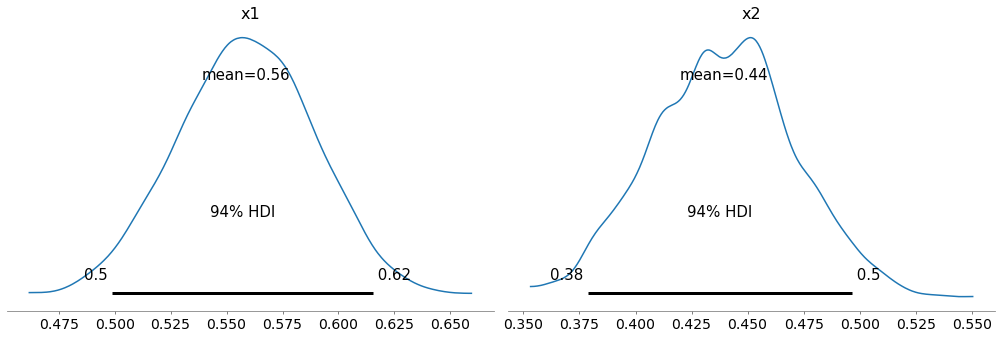

In [11]:
import arviz as az

with model1:
    az.plot_posterior(trace1)

The results for the first coin are about the same as what we saw in the previous notebook. The results for the second coin are similar, but the center of the distribution is lower, because the observed value of `k` is smaller.

This model is not exactly wrong, but it is not as right as it could be, because we are leaving some information on the table.

That's because the data we have about each coin actually provides two kinds of information: it tells us about each coin individually, and it also tells us about coins in general.

By estimating `x1` and `x2` separately, we are using the first kind of information, but not the second.

An alternative is to use a **hierarchical model**.

## Going hierarchical

In the previous model, the prior distribution is a beta distribution with values of `alpha` and `beta` that I chose with the intention of representing the information we have about coins and their probability of coming up heads.
But my choice of these parameters was almost arbitrary.

Instead of choosing these parameters ourselves, an alternative is to add them to the model and use the data to estimate them.

Here's a version of the previous model where `alpha` and `beta` are values drawn from a gamma distribution.

In [12]:
with pm.Model() as model2:
    alpha = pm.Gamma('alpha', alpha=4, beta=0.5)
    beta = pm.Gamma('beta', alpha=4, beta=0.5)
    x1 = pm.Beta('x1', alpha, beta)
    x2 = pm.Beta('x2', alpha, beta)
    k1 = pm.Binomial('k1', n=n, p=x1, observed=140)
    k2 = pm.Binomial('k2', n=n, p=x2, observed=110)

Here's the graph for this model.

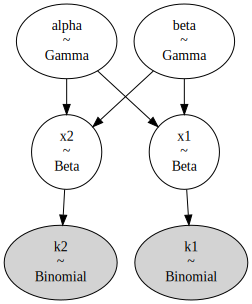

In [13]:
pm.model_to_graphviz(model2)

This model is hierarchical because the variables can be arranged in layers.

At the top level, `alpha` and `beta` are **hyperparameters** drawn from a two gamma distributions, which are called **hyperprior distributions**.

At the next level, these hyperparameters are used to define the prior distributions of `x1` and `x2`.

At the bottom level, these parameters are used to define the distributions of `k1` and `k2`, which are the observed values.

Before we sample from the posterior distributions, let's look at the prior and prior predictive distributions.

In [14]:
with model2:
    trace2 = pm.sample_prior_predictive(500)

Here are the distributions of the hyperparameters, `alpha` and `beta`.

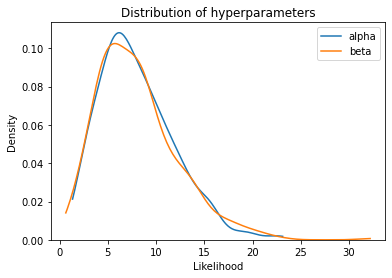

In [15]:
plot_kde(trace2['alpha'], label='alpha')
plot_kde(trace2['beta'], label='beta')
plt.xlabel('Hyperparameter')
plt.xlabel('Likelihood')
plt.title('Distribution of hyperparameters')
plt.legend();

And here's the prior distributions for `x1` and `x2`.

In [16]:
sample_prior_x1 = trace2['x1']
sample_prior_x2 = trace2['x2']
sample_prior_x1.mean(), sample_prior_x2.mean()

(0.5004863666560911, 0.5080980121767277)

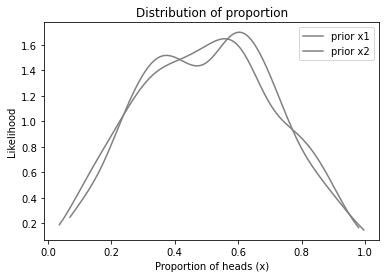

In [17]:
plot_kde(sample_prior_x1, color='gray', label='prior x1')
plot_kde(sample_prior_x2, color='gray', label='prior x2')
decorate_proportion()

The priors for `x1` and `x2` are actually the same, but based on random samples, they look a little different.

Now we're ready to sample from the posteriors.

## Posterior distributions

Let's run the sampler.

In [18]:
with model2:
    trace2 = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x2, x1, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


And here are the results.

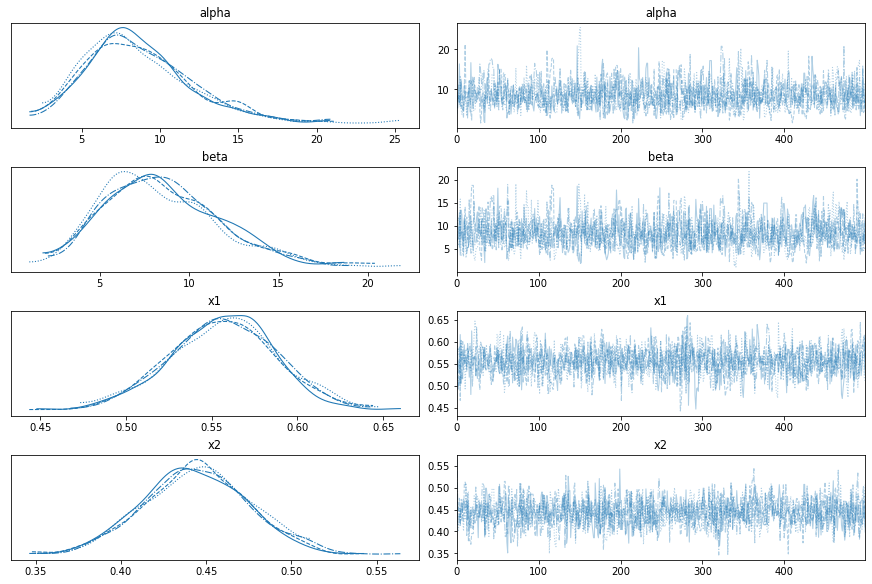

In [19]:
with model2:
    az.plot_trace(trace2)

Here are the posterior distributions for `x1` and `x2`.

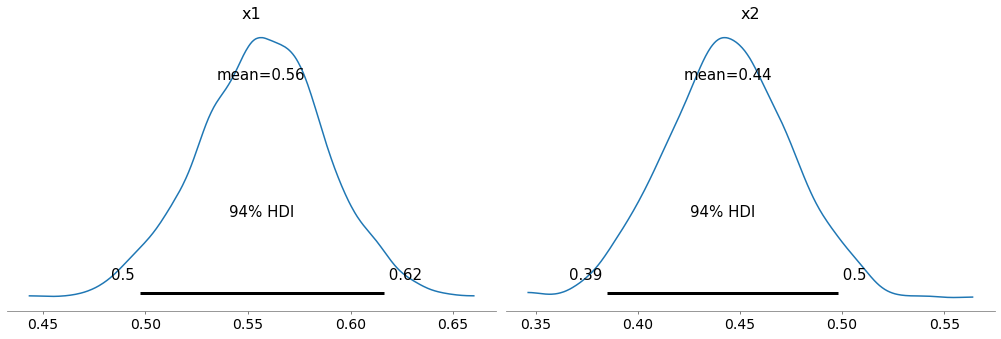

In [20]:
with model2:
    az.plot_posterior(trace2, var_names=['x1', 'x2'])

In this example, they are not very different from what we got by estimating `x1` and `x2` separately.
If we had less data, the hierarchical model would make more difference.

But even if the distributions of the parameters are the same, the hierarchical model is different because the we have posterior distributions for the hyperparameters, `alpha` and `beta`.

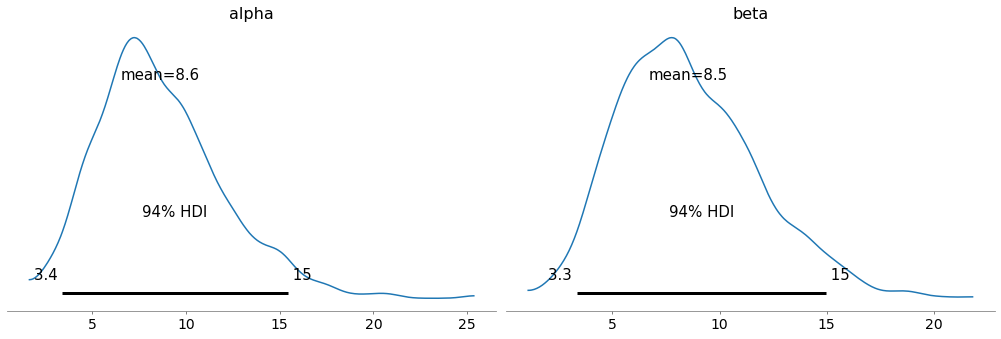

In [21]:
with model2:
    az.plot_posterior(trace2, var_names=['alpha', 'beta'])

By themselves, they don't mean very much, but we can use them to generate a sample from a beta distribution.

In [22]:
alphas = trace2['alpha']
betas = trace2['beta']

sample_posterior_x = pm.Beta.dist(alphas, betas).random()
sample_posterior_x.mean()

0.49964849585757276

The result is a distribution that represents what we believe about coins in general, based on the data from both coins.
Here's what it looks like, compared to the prior.

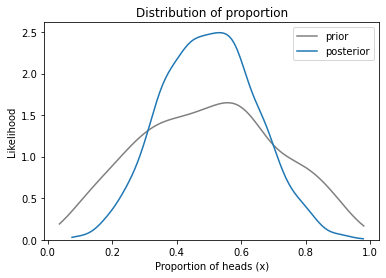

In [23]:
plot_kde(sample_prior_x1, color='gray', label='prior')
plot_kde(sample_posterior_x, label='posterior')
decorate_proportion()

The posterior distribution is narrower than the posterior, which means we have more certainty about plausible values of `x`.
Specifically, after seeing this data, we think values of `x` near 0.5 are more likely, and values at the extremes are less likely.

In this example, we don't learn a lot about coins because we don't have a lot of data.
So let's look at an example with more data, where we can see the utility of the hierarchical model more clearly.

## Heart Attack Data

This example is based on [Chapter 10 of *Probability and Bayesian Modeling*](https://bayesball.github.io/BOOK/bayesian-hierarchical-modeling.html#example-deaths-after-heart-attack); it uses data on death rates due to heart attack for patients treated at various hospitals in New York City.

We can use Pandas to read the data into a `DataFrame`.

In [24]:
import os

filename = 'DeathHeartAttackManhattan.csv'
if not os.path.exists(filename):
    !wget https://github.com/AllenDowney/BayesianInferencePyMC/raw/main/DeathHeartAttackManhattan.csv

--2021-07-15 17:49:08--  https://github.com/AllenDowney/BayesianInferencePyMC/raw/main/DeathHeartAttackManhattan.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/BayesianInferencePyMC/main/DeathHeartAttackManhattan.csv [following]
--2021-07-15 17:49:08--  https://raw.githubusercontent.com/AllenDowney/BayesianInferencePyMC/main/DeathHeartAttackManhattan.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 560 [text/plain]
Saving to: ‘DeathHeartAttackManhattan.csv’

DeathHeartAttackMan 100%[===================>]     560  --.-KB/s    in 0s      

2021-07-15 17:49:08 (12.9 MB/s) - ‘Dea

In [25]:
import pandas as pd

df = pd.read_csv(filename)
df

,Hospital,Cases,Deaths,Death %
0,Bellevue Hospital Center,129,4,3.101
1,Harlem Hospital Center,35,1,2.857
2,Lenox Hill Hospital,228,18,7.894
3,Metropolitan Hospital Center,84,7,8.333
4,Mount Sinai Beth Israel,291,24,8.247
5,Mount Sinai Hospital,270,16,5.926
6,Mount Sinai Roosevelt,46,6,13.043
7,Mount Sinai St. Luke’s,293,19,6.485
8,NYU Hospitals Center,241,15,6.224
9,NYP Hospital - Allen Hospital,105,13,12.381


The columns we need are `Cases`, which is the number of patients treated at each hospital, and `Deaths`, which is the number of those patients who died.

In [26]:
data_ns = df['Cases'].values
data_ks = df['Deaths'].values

Here's a hierarchical model that estimates the death rate for each hospital, and simultaneously estimates the distribution of rates across hospitals.

In [27]:
with pm.Model() as model4:
    alpha = pm.Gamma('alpha', alpha=4, beta=0.5)
    beta = pm.Gamma('beta', alpha=4, beta=0.5)
    xs = pm.Beta('xs', alpha, beta, shape=len(data_ns))
    ks = pm.Binomial('ks', n=data_ns, p=xs, observed=data_ks)
    trace4 = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [xs, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.


Here's the trace.

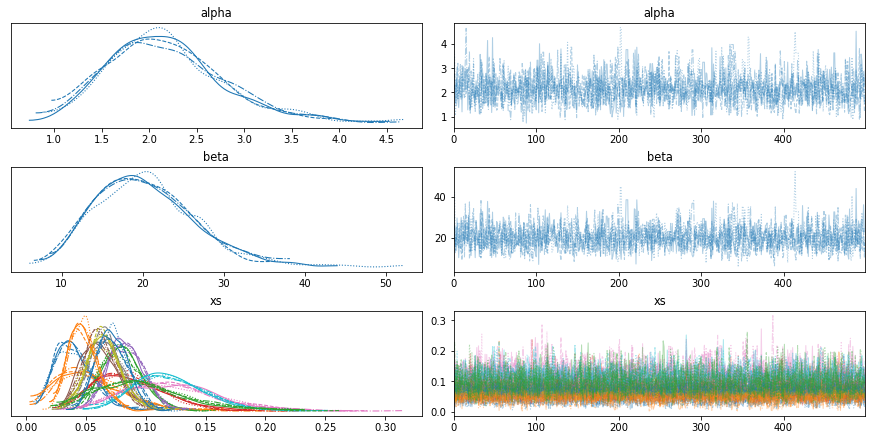

In [28]:
with model4:
    az.plot_trace(trace4)

Here are the posterior distributions for the hospitals. Notice that some of them are wider than others, because some hospitals treated more patients than others.

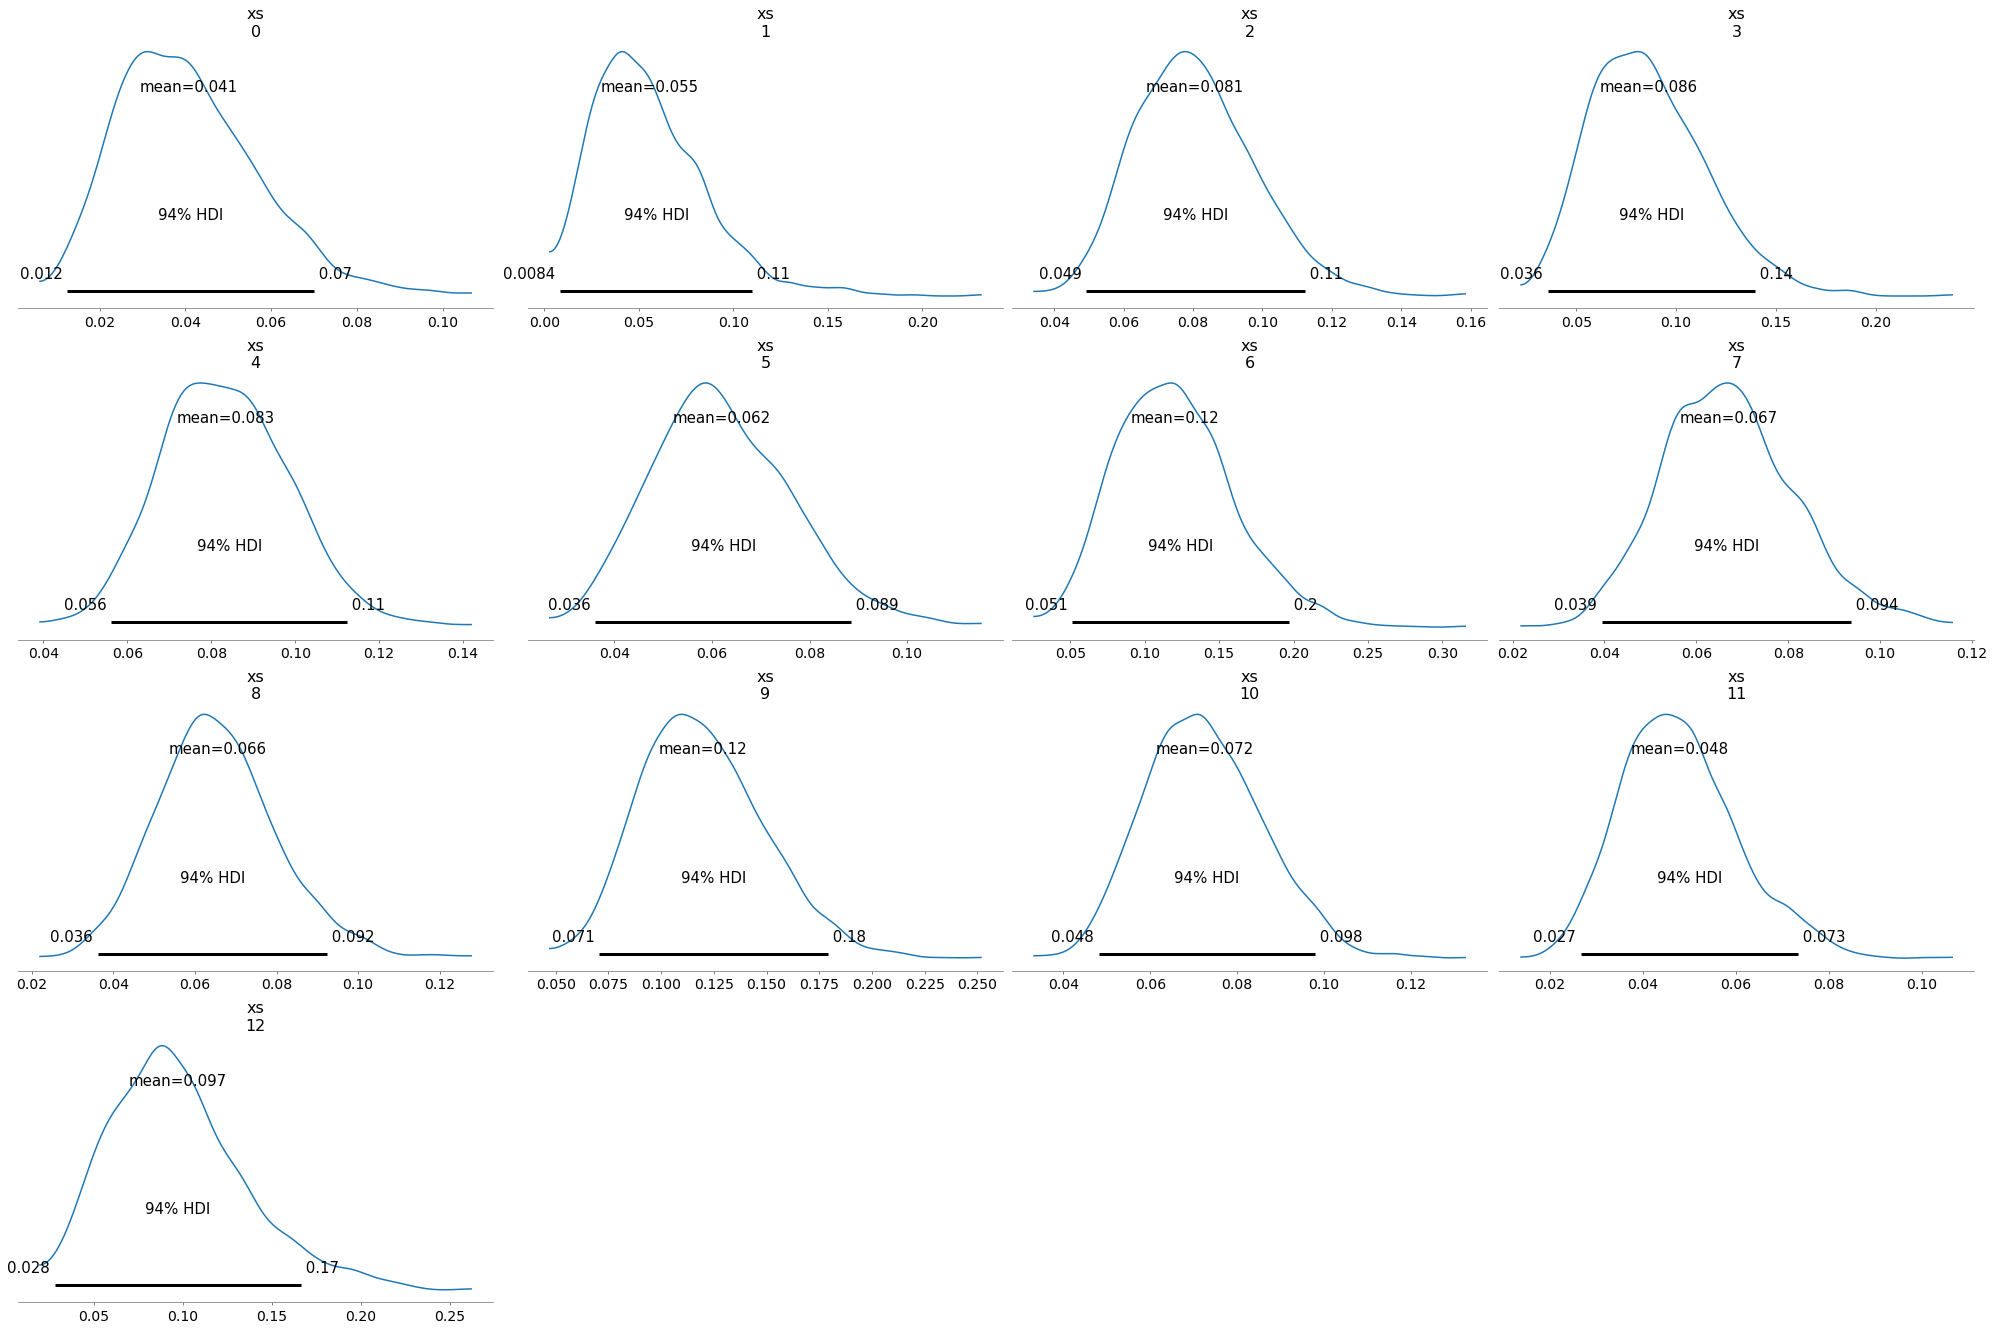

In [29]:
with model4:
    az.plot_posterior(trace4, var_names=['xs'])

Here are the posterior distributions for `alpha` and `beta`.

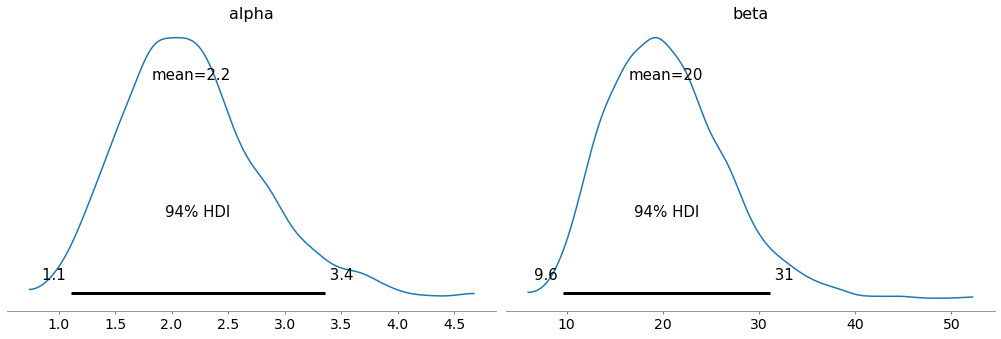

In [30]:
with model4:
    az.plot_posterior(trace4, var_names=['alpha', 'beta'])

The posterior distributions of the hyperparameters don't mean much by themselves, but we can use them to compute the posterior distribution of `x`.

In [31]:
alphas = trace4['alpha']
betas = trace4['beta']

In [32]:
sample_posterior_x = pm.Beta.dist(alphas, betas).random()
sample_posterior_x.mean()

0.09895973324653017

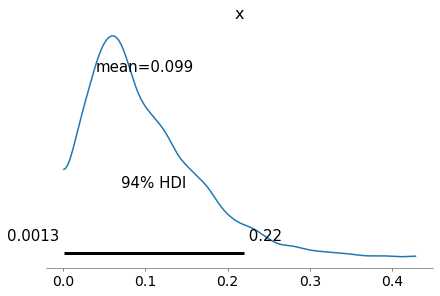

In [33]:
with model4:
    az.plot_posterior(sample_posterior_x)

This distribution represents what we believe about the distribution of death rates across different hospitals, based on the data.

NOTE: I used gamma distributions for the hyperparameters because they are simple, they work well with the PyMC sampler, and they are good enough for this example. But they are not the most common choice for a hierarchical beta-binomial model.
[The chapter I got this example from](https://bayesball.github.io/BOOK/bayesian-hierarchical-modeling.html#example-deaths-after-heart-attack) has a good explanation of a more common way to parameterize this model.

## Poisson model

Let's look at one more example of a hierarchical model, based on the hockey example we started with.

Remember that we used a gamma distribution to represent the distribution of the rate parameters, `mu`.
I chose the parameters of that distribution, `alpha` and `beta`, based on results from previous NHL playoff games.

An alternative is to use a hierarchical model, where `alpha` and `beta` are hyperparameters.  Then we can use data to update estimate the distribution of `mu` for each team, and to estimate the distribution of `mu` across teams.

Of course, now we need a prior distribution for `alpha` and `beta`.  A common choice is the half Cauchy distribution (see [Gelman](http://www.stat.columbia.edu/~gelman/research/published/taumain.pdf)), but on advice of counsel, I'm going with exponential.

Here's a model that generates the prior distribution of `mu`.

In [34]:
with pm.Model() as model5:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    trace5 = pm.sample_prior_predictive(1000)

/home/downey/anaconda3/envs/BayesianInferencePyMC/lib/python3.9/site-packages/pymc3/distributions/transforms.py:221: RuntimeWarning: divide by zero encountered in log
  return np.log(x)


In [35]:
sample_prior_mu = trace5['mu']
sample_prior_mu.mean()

4.080222022553976

Here's what the prior distribution of `mu` looks like.

In [36]:
def decorate_rate(ylabel='Density'):
    """Decorate the axes."""
    plt.xlabel('Goals per game (mu)')
    plt.ylabel(ylabel)
    plt.title('Distribution of goal scoring rate')
    legend()

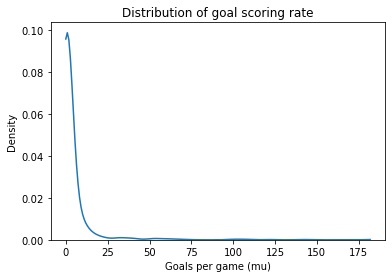

In [37]:
plot_kde(sample_prior_mu)
decorate_rate()

This is a long-tailed distribution, with highest probability for values less than 100, but it admits the possibility that `mu` could be orders of magnitude bigger. Unreasonable as that might seem, it's probably what we want in a non-committal prior.

Now suppose a team plays one game and scores 4 goals.
We can run the hierarchical model with this data. 

In [38]:
with pm.Model() as model6:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=[4])

Here's what the model looks like.

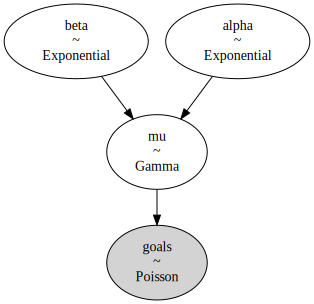

In [39]:
pm.model_to_graphviz(model6)

Now we can run the sampler.

In [40]:
with model6:
    trace6 = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


This model does not behave as well as the others. In particular, it is likely to "diverge" a few times during the sampling process.
When we plot the trace, we see these divergences as gray lines.

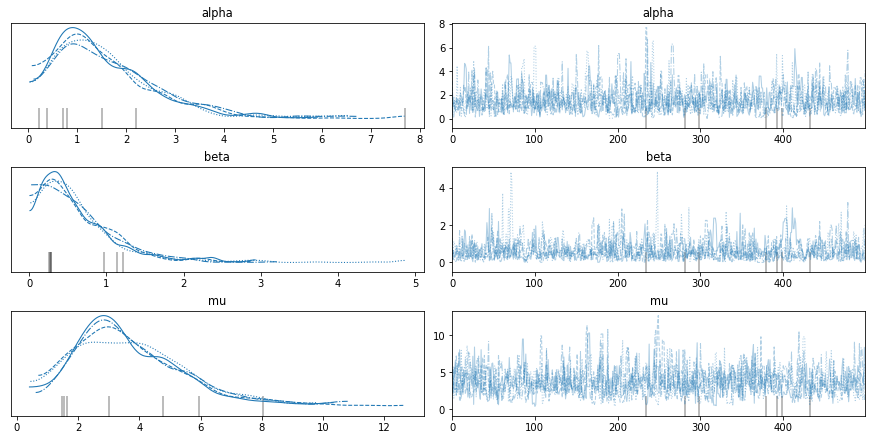

In [41]:
with model6:
    az.plot_trace(trace6)

There are ways to tune the sampler to reduce the number of divergences, but I won't bother because the visual diagnostics look fine.

Here's the posterior distribution of `mu`.  The posterior mean is close to the observed value, which is what we expect with a weakly informative prior.

In [42]:
sample_post_mu = trace6['mu']
sample_post_mu.mean()

3.7200441351828

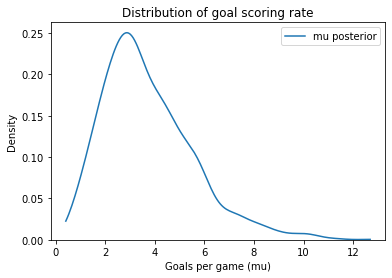

In [43]:
plot_kde(sample_post_mu, label='mu posterior')
decorate_rate()

After one game, it seems like we have learned a lot about typical scoring rates in hockey.

## Two teams

Here's the hierarchical version of the model for two teams.

In [44]:
with pm.Model() as model7:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu_A = pm.Gamma('mu_A', alpha, beta)
    mu_B = pm.Gamma('mu_B', alpha, beta)
    goals_A = pm.Poisson('goals_A', mu_A, observed=[5,3])
    goals_B = pm.Poisson('goals_B', mu_B, observed=[1,1])
    trace7 = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_B, mu_A, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


We can use `traceplot` to review the results and do some visual diagnostics.

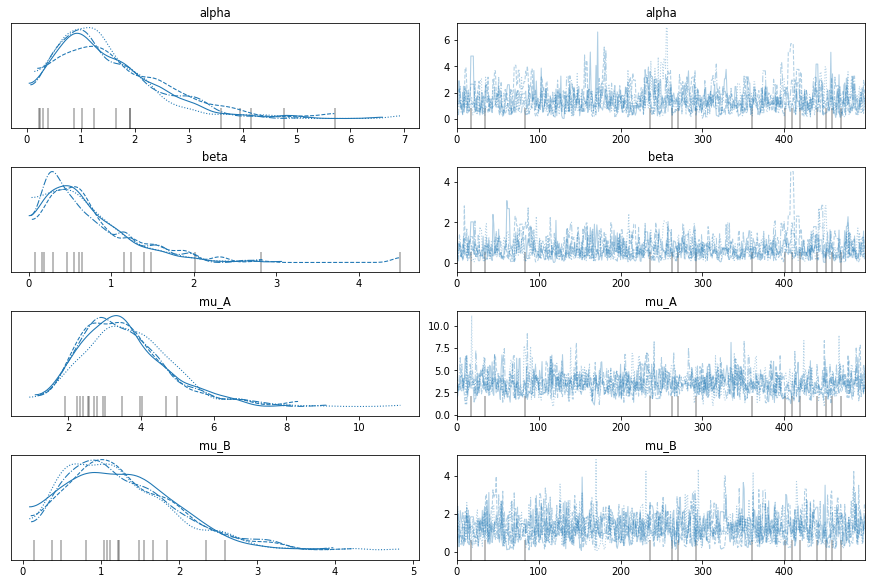

In [45]:
with model7:
    az.plot_trace(trace7)

Here are the posterior distributions for the two teams.

In [46]:
mu_A = trace7['mu_A']
mu_B = trace7['mu_B']
mu_B.mean(), mu_A.mean()

(1.2781377363818707, 3.555426694346786)

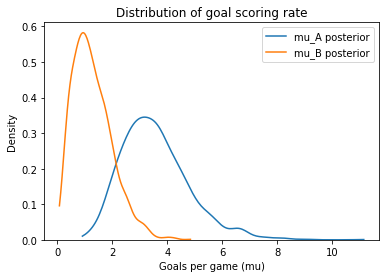

In [47]:
plot_kde(mu_A, label='mu_A posterior')
plot_kde(mu_B, label='mu_B posterior')
decorate_rate('Density')

And here's the probability that A is the better team.

In [48]:
(mu_A > mu_B).mean()

0.968

## More background

But let's take advantage of more information.  Here are the results from the most recent Stanley Cup finals.
For games that went into overtime, I included only goals scored during regulation play.

In [49]:
data = dict(BOS13 = [3, 1, 2, 5, 1, 2],
            CHI13 = [3, 1, 0, 5, 3, 3],
            NYR14 = [2, 4, 0, 2, 2],
            LAK14 = [2, 4, 3, 1, 2],
            TBL15 = [1, 4, 3, 1, 1, 0],
            CHI15 = [2, 3, 2, 2, 2, 2],
            SJS16 = [2, 1, 2, 1, 4, 1],
            PIT16 = [3, 1, 2, 3, 2, 3],
            NSH17 = [3, 1, 5, 4, 0, 0],
            PIT17 = [5, 4, 1, 1, 6, 2],
            VGK18 = [6, 2, 1, 2, 3],
            WSH18 = [4, 3, 3, 6, 4],
            STL19 = [2, 2, 2, 4, 2, 1, 4],
            BOS19 = [4, 2, 7, 2, 1, 5, 1],
            DAL20 = [4, 2, 2, 4, 2, 0],
            TBL20 = [1, 3, 5, 4, 2, 2],
            MTL21 = [1, 1, 3, 2, 0],
            TBL21 = [5, 3, 6, 2, 1])

Here's how we can get the data into the model.

In [50]:
with pm.Model() as model8:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    
    mu = dict()
    goals = dict()
    for name, observed in data.items():
        mu[name] = pm.Gamma('mu_'+name, alpha, beta)
        goals[name] = pm.Poisson(name, mu[name], observed=observed)
        
    trace8 = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_TBL21, mu_MTL21, mu_TBL20, mu_DAL20, mu_BOS19, mu_STL19, mu_WSH18, mu_VGK18, mu_PIT17, mu_NSH17, mu_PIT16, mu_SJS16, mu_CHI15, mu_TBL15, mu_LAK14, mu_NYR14, mu_CHI13, mu_BOS13, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 6 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


And here are the results.

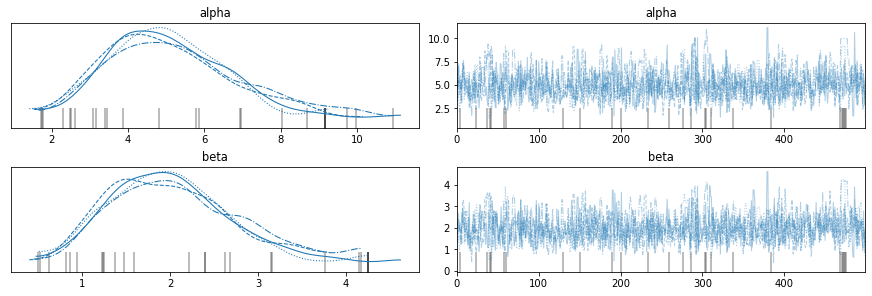

In [51]:
with model8:
    az.plot_trace(trace8, var_names=['alpha', 'beta'])

Here are the posterior means for the hyperparameters.

In [52]:
sample_post_alpha = trace8['alpha']
sample_post_alpha.mean()

5.073049647974402

In [53]:
sample_post_beta = trace8['beta']
sample_post_beta.mean()

2.012057513824273

So in case you were wondering how I chose the parameters of the gamma distribution in the first notebook.
That's right -- time travel.

In [54]:
sample_post_mu_TBL21 = trace8['mu_TBL21']
sample_post_mu_MTL21 = trace8['mu_MTL21']
sample_post_mu_TBL21.mean(), sample_post_mu_MTL21.mean()

(3.168661616874274, 1.7254649819242764)

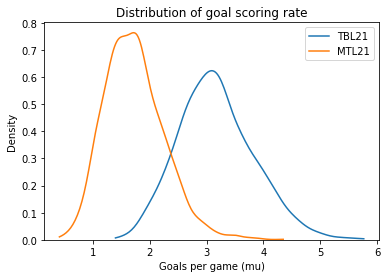

In [55]:
plot_kde(sample_post_mu_TBL21, label='TBL21')
plot_kde(sample_post_mu_MTL21, label='MTL21')
decorate_rate()

Here's the updated chance that Tampa Bay is the better team.

In [56]:
(sample_post_mu_TBL21 > sample_post_mu_MTL21).mean()

0.9645